In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
from scipy.spatial import distance
import functools

In [2]:
df0 = pd.read_csv('c:/Users/gandh/dev/unv/smoed/me/data/main_data.csv')
X = df0['nu']
Y = df0['E']

Text(0.5, 0.98, 'Двумерная выборка')

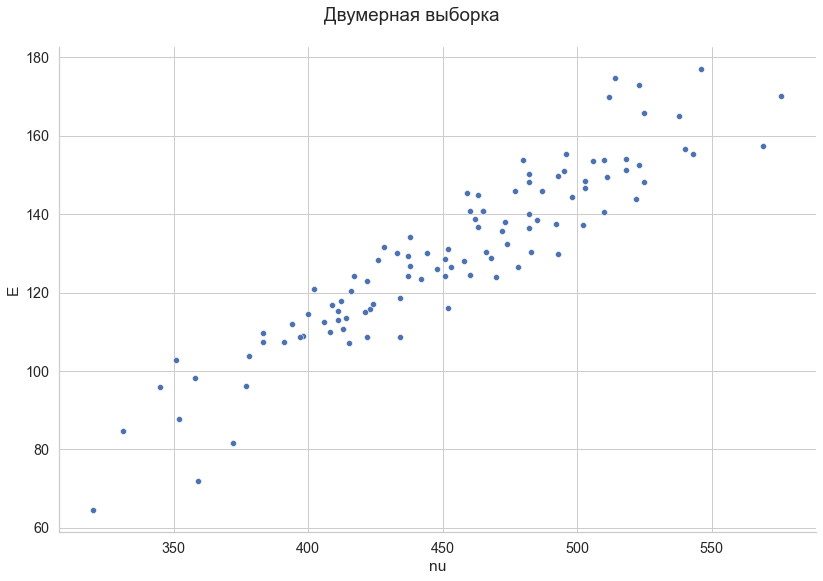

In [3]:
sns.set_theme(style="whitegrid", palette='deep', context='notebook', font_scale=1.3)
ax = sns.relplot(data=df0, x='nu', y='E', kind='scatter', height=8.27, aspect=11.7/8.27)
ax.set_axis_labels('nu', 'E')
ax.fig.suptitle('Двумерная выборка')
plt.tight_layout()
plt.savefig('pics/0.png')

In [4]:
X_norm = StandardScaler().fit_transform(df0)
df = pd.DataFrame(data=X_norm, columns=['nu','E'])
df.to_csv('data/df_norm.csv', index=False)

Text(0.5, 0.98, 'Нормализованная выборка')

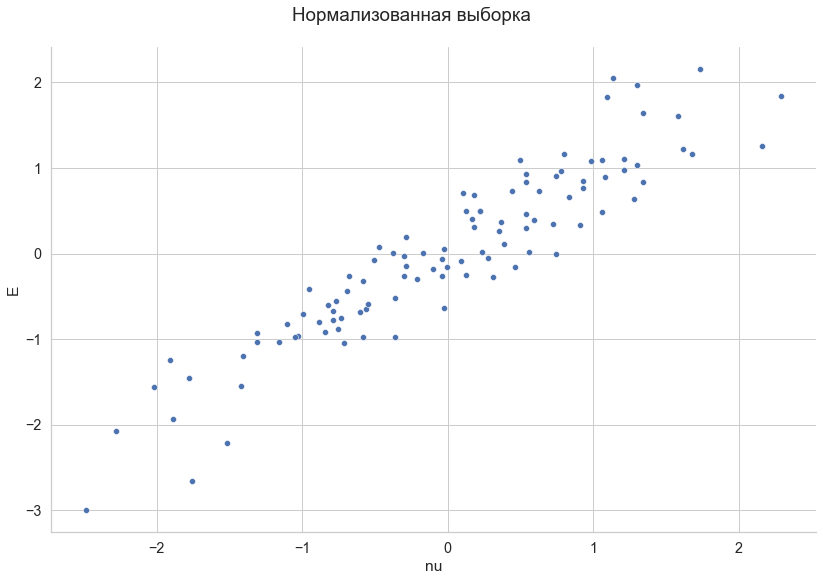

In [5]:
sns.set_theme(style="whitegrid", palette='deep', context='notebook', font_scale=1.3)
ax = sns.relplot(data=df, x='nu', y='E', kind='scatter', height=8.27, aspect=11.7/8.27)
ax.set_axis_labels('nu', 'E')
ax.fig.suptitle('Нормализованная выборка')
plt.tight_layout()
plt.savefig('pics/1.png')

## Алгоритм

In [6]:
def sc_plots(data, center, R, step, itera):   
    ax = sns.relplot(data=data, x='nu', y='E', hue='cluster', kind='scatter', palette='deep',
                     alpha=0.9, height=8.27, aspect=11.7/8.27)
    for j in [center]:
        plt.scatter(j[0],j[1], c='k', s=70)    
#     print(center.values[:2])
#     print(data[data['cluster']!=1]['nu'].count())

    circle = np.array([], dtype=np.float64)     
    for i in data[data['cluster']!=-1].values:       
        circle = np.append(circle, np.linalg.norm(i[:-1]-center.values[:2]))
    
    plt.scatter(j[0], j[1], linewidths=1, facecolors='crimson', edgecolors='crimson', s=max(circle)*2*35000, alpha=0.1)
    
    ax.set_axis_labels('nu', 'E')
    ax.fig.suptitle(f'Кластер {itera}, шаг {step}; центр = ({center.values[0].round(4)}; {center.values[1].round(4)}); N = {data[data["cluster"]!=-1]["nu"].count()}')
    ax.set(xlim=[-3.5,3.5], ylim=[-3.5,3.5])
    plt.tight_layout()
    plt.savefig(f'pics/{itera}_{step}.png')
    plt.show()

In [7]:
def Fs(data):
    curr_data = data.copy()
    cts = curr_data.groupby('cluster').mean()
    F1,F2,F3 = 0,0,0
    
    # F1 - сумма кв. расст. точек до центров соотв. кластеров
    for i in range(len(curr_data)):        
        dist_F1 = np.linalg.norm(curr_data.iloc[i,:-1].values-cts.values[curr_data.iloc[i,2]-1])
        F1 += dist_F1**2
        
    # F2 - сумма кв. расст. до всех точек соотв. кластеров    
    for i in range(1,len(cts)+1):
        coords = curr_data[curr_data['cluster']==i].iloc[:,:2].values
        dist_F2 = distance.cdist(coords, coords, 'euclidean')
        F2 += (np.triu(dist_F2,0)**2).sum()

    # F3 - сумма внутрикластерных дисперсий
    F3 = curr_data.groupby('cluster').var().values.sum(where=~np.isnan(curr_data.groupby('cluster').var().values), initial=0)
    
    return F1,F2,F3

In [8]:
def custFE(cur_data, R, itera, plots=1, max_iter=20): 
    cur_dist = np.array([], dtype=np.float64)
    data = cur_data.copy()
    coords = data.values

    # расстояние между объектами
    dist = distance.cdist(coords, coords, 'euclidean') 
    data['cluster'] = -1

    # сколько объектов с растоянием < R для каждого объекта
    for i in dist:
        cur_dist = np.append(cur_dist, len(i[np.where((i>=0) & (i<=R))])) 

    # индекс центра
    center_ind = np.argmax(cur_dist) 
    # индексы объектов с расстоянием < R до центра
    cluster_ind = np.where((dist[np.argmax(cur_dist)]>=0) &
                           (dist[np.argmax(cur_dist)]<=R))
    data.iloc[cluster_ind[0],2] = itera
    data.iloc[center_ind,2] = itera
    if plots == 1:
        sc_plots(data, data.iloc[center_ind], R, 1, itera)
    cur_center = data.iloc[center_ind]
    
    for it in range(max_iter):
        distl = np.array([], dtype=np.float64)
        # новый центр тяжетси
        center = data[data['cluster']==itera].mean()
        data['cluster'] = -1

        # расстояния до нового центра
        for i in data.iloc[:,:2].values:
            distl = np.append(distl, np.linalg.norm(center[:-1].values-i))
        cluster_ind = np.where((distl>=0) & (distl<=R))

        data.iloc[cluster_ind[0],2] = itera

        if functools.reduce(lambda x, y : x and y, map(lambda p, q: p == q,center.values,cur_center.values), True):
            break
        if plots == 1:
            sc_plots(data, center, R, it+2, itera)
        cur_center = center

    # график
    if plots == 0:
        sc_plots(data, center, R, 'последний', itera)
    
    return data[data['cluster']==-1], data, np.array(center.values[:2])

## Основа

In [9]:
coords = df.values
dist = np.triu(distance.cdist(coords, coords, 'euclidean'), 0)
rmin = np.amin(dist, where=dist!=0, initial=10)
rmax = np.amax(dist)
rmin.round(4), rmax.round(4)

(0.0092, 6.8015)

In [22]:
upd_df = df.copy()
it = 1
radius = 1.13
df['cluster'] = -1
ctrs = np.array([], dtype=np.float64)

In [23]:
while len(upd_df):
    upd_df, main, ctr = custFE(upd_df, radius, it, 2)
    ctrs = np.append(ctrs, [ctr])
    it += 1    
    df.loc[main[main['cluster']!=-1].index, :] = main.loc[main[main['cluster']!=-1].index, :]
df.to_csv('data/result.csv', index=False)

### Финальное разбиение

In [24]:
F1, F2, F3 = Fs(df)
F1, F2, F3

(41.1501518936842, 1944.8671818142218, 1.6772312179764923)

In [18]:
F1, F2, F3 = Fs(df)
F1, F2, F3

(41.07730827411169, 1928.5299047289113, 1.6818686788067756)

In [21]:
F1, F2, F3 = Fs(df)
F1, F2, F3

(43.69071146863348, 2144.7389621773955, 1.4447270205641565)

Text(0.5, 0.98, 'Кластеры 5')

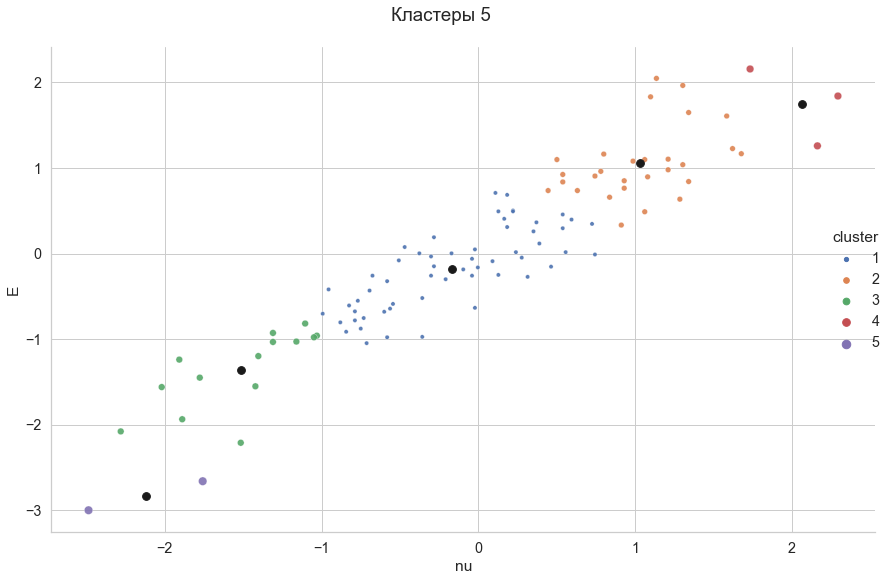

In [15]:
ax = sns.relplot(data=df, x='nu', y='E', hue='cluster', kind='scatter', palette='deep', alpha=0.9,
                 size='cluster', height=8.27, aspect=11.7/8.27)
ctrs = ctrs.reshape((-1,2))
for i in ctrs:
    plt.scatter(i[0], i[1], c='k', s=60)
ax.set_axis_labels('nu', 'E')
ax.fig.suptitle(f'Кластеры {len(df["cluster"].unique())}')
plt.tight_layout()
plt.savefig('pics/result.png')
plt.show()